In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [57]:
df = pd.read_csv('data/dataset_with_clusters.csv')
df.head(3)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name,BMR,PAL,TDEE,E_raw,E_eff,E,pct_HRR,I,workload,S,Duration_min,D,pen_age,pen_bmi,pen_hrr,pen_skill,R,C,P,cal_from_protein,cal_from_carbs,cal_from_fats,pct_p,pct_c,pct_f,M,ED,F,diet_type,Cluster,cluster_description
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.870447,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch,1495.20,1.900,2840.88000,0.295123,0.845312,0.570217,0.741237,0.526466,105,0.250000,60.0,0.333333,0.404762,0.336004,0.0,1,0.637294,0.521061,0.342572,424.20,1070.72,644.67,0.198262,0.500432,0.301305,0.697313,0.258372,0.173291,Vegan,1.0,Normal weight & low activity
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.479709,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch,1256.85,1.900,2388.01500,0.579037,0.902949,0.740993,0.551247,0.256055,64,0.225000,82.2,0.575163,0.119048,0.299589,0.0,0,0.862504,0.454991,0.211067,341.64,857.28,512.73,0.199597,0.500850,0.299553,0.696730,0.247696,0.471934,Vegetarian,1.0,Normal weight & low activity
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.148123,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast,1307.55,1.725,2255.52375,0.186606,0.912713,0.549660,0.574534,0.289199,110,0.416667,54.6,0.274510,0.357143,0.238540,0.0,1,0.685581,0.695902,0.604530,392.44,984.16,589.32,0.199622,0.500610,0.299768,0.697190,0.082439,0.096575,Paleo,0.0,Overweight & low activity


In [58]:
user = pd.read_csv('data/new_user.csv')
user.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,diet_type,Experience_Level,Goal,WeightChange (kg),GoalDays,BMR,PAL,TDEE,CalorieChange,CloriesToBurnTraining,CloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout,Meal_target,Cluster
0,38,Female,100,1.7,34.602076,3,2,Low-Carb,2,Loss,5,30,1711.5,1.725,2952.3375,38500,19250.0,19250.0,2310.670833,13.0,1480.769231,1155.335417,0


In [59]:
meals = pd.read_csv('data/meal.csv')
meals.head(3)

,meal_name,Calories,Proteins,Carbs,Fats,sugar_g,serving_size_g,sodium_g,cholesterol_g,C,P,M,ED,F
0,Grilled Vegan Lunch,1806.0,106.05,267.68,71.63,31.77,120.47,1.72994,0.28505,0.521061,0.342572,0.697313,0.258372,0.173291
1,Fried Vegetarian Lunch,1577.0,85.41,214.32,56.97,12.34,109.15,0.69308,0.30061,0.454991,0.211067,0.696730,0.247696,0.471934
2,Boiled Paleo Breakfast,1608.0,98.11,246.04,65.48,42.81,399.43,2.14248,0.21542,0.695902,0.604530,0.697190,0.082439,0.096575


TRAIN DATASET:

In [60]:
if user['Goal'].iloc[0] == 'Loss':
    df['pseudo_target'] = 0.35*df['C'] + 0.25*df['P'] + 0.15*df['M'] + 0.15*df['ED'] + 0.1*df['F']
elif user['Goal'].iloc[0] == 'Maintain':
    df['pseudo_target'] = 0.3*df['C'] + 0.25*df['M'] + 0.2*df['P'] + 0.1*df['ED'] + 0.15*df['F']
elif user['Goal'].iloc[0] == 'Gain':
    df['pseudo_target'] = 0.4*df['C'] + 0.3*df['P'] + 0.15*df['M'] + 0.1*df['ED'] + 0.05*df['F']

In [61]:
df = df[['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'BMI', 'Workout_Frequency (days/week)', 'Daily meals frequency', 'diet_type',
         'Experience_Level', 'Cluster', 'meal_name', 'Calories', 'Proteins', 'Carbs', 'Fats', 'sugar_g', 'serving_size_g',
         'sodium_g', 'cholesterol_g', 'C', 'P', 'M', 'ED', 'F', 'pseudo_target']]
df.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,diet_type,Experience_Level,Cluster,meal_name,Calories,Proteins,Carbs,Fats,sugar_g,serving_size_g,sodium_g,cholesterol_g,C,P,M,ED,F,pseudo_target
0,35,Male,65.27,1.62,24.870447,4,3,Vegan,2,1.0,Grilled Vegan Lunch,1806.0,106.05,267.68,71.63,31.77,120.47,1.72994,0.28505,0.521061,0.342572,0.697313,0.258372,0.173291,0.428696
1,23,Female,56.41,1.55,23.479709,4,3,Vegetarian,2,1.0,Fried Vegetarian Lunch,1577.0,85.41,214.32,56.97,12.34,109.15,0.69308,0.30061,0.454991,0.211067,0.696730,0.247696,0.471934,0.400871
2,33,Female,58.98,1.67,21.148123,3,2,Paleo,1,0.0,Boiled Paleo Breakfast,1608.0,98.11,246.04,65.48,42.81,399.43,2.14248,0.21542,0.695902,0.604530,0.697190,0.082439,0.096575,0.521300


USER MEAL DATASET:

In [62]:
user_predict = user[['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'BMI', 'Workout_Frequency (days/week)', 'Daily meals frequency', 'diet_type',
         'Experience_Level', 'Cluster']]

user_predict_repeated = pd.concat([user_predict]*len(meals), ignore_index=True)
meal_predict = pd.concat([user_predict_repeated, meals.reset_index(drop=True)], axis=1)
meal_predict.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,diet_type,Experience_Level,Cluster,meal_name,Calories,Proteins,Carbs,Fats,sugar_g,serving_size_g,sodium_g,cholesterol_g,C,P,M,ED,F
0,38,Female,100,1.7,34.602076,3,2,Low-Carb,2,0,Grilled Vegan Lunch,1806.0,106.05,267.68,71.63,31.77,120.47,1.72994,0.28505,0.521061,0.342572,0.697313,0.258372,0.173291
1,38,Female,100,1.7,34.602076,3,2,Low-Carb,2,0,Fried Vegetarian Lunch,1577.0,85.41,214.32,56.97,12.34,109.15,0.69308,0.30061,0.454991,0.211067,0.696730,0.247696,0.471934
2,38,Female,100,1.7,34.602076,3,2,Low-Carb,2,0,Boiled Paleo Breakfast,1608.0,98.11,246.04,65.48,42.81,399.43,2.14248,0.21542,0.695902,0.604530,0.697190,0.082439,0.096575


In [63]:
numerical_features = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 
                      'Workout_Frequency (days/week)', 'Daily meals frequency', 'Proteins', 'Carbs', 'Fats', 'sugar_g', 'serving_size_g',
                      'sodium_g', 'cholesterol_g']

categorical_features = ['Gender', 'diet_type', 'Experience_Level', 'Cluster', 'meal_name']

In [64]:
X = df.drop(columns=['pseudo_target', 'C', 'P', 'M', 'ED', 'F', 'Calories'])
y = df['pseudo_target']

X_encoded = pd.get_dummies(
    X,
    columns=categorical_features,
    drop_first=True
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42
)

In [65]:
model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # встроенная метрика RMSE
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший RMSE на кросс-валидации:", -grid_search.best_score_)  # переворачиваем знак

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Лучший RMSE на кросс-валидации: 0.01340077205381636


In [ ]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=1.0,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f"RMSE (pseudo-label): {rmse}")

RMSE (pseudo-label): 0.013172899638471248


<Figure size 2000x7000 with 0 Axes>

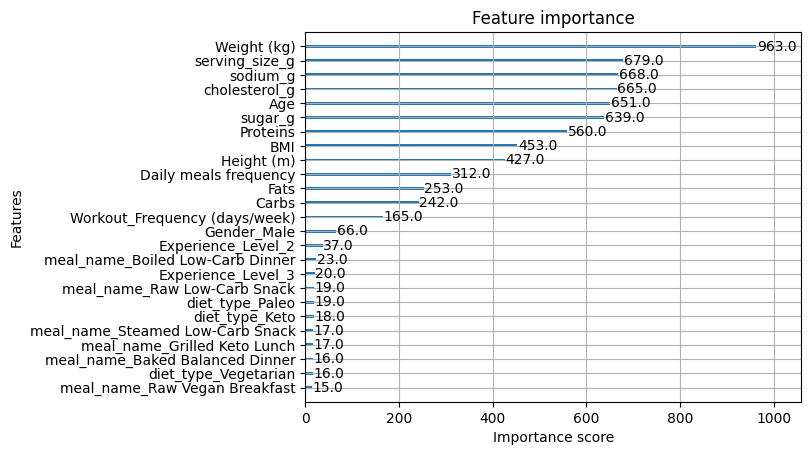

In [67]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# График важности фич
plt.figure(figsize=(20, 70))
plot_importance(model, importance_type='weight', max_num_features=25) 
plt.show()

In [68]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R^2 on test sample: {r2}")

R^2 on test sample: 0.985085973386503


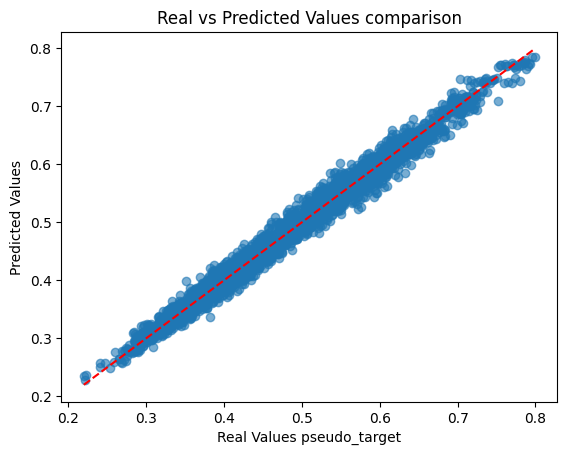

In [69]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Real Values pseudo_target")
plt.ylabel("Predicted Values")
plt.title("Real vs Predicted Values comparison")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [70]:
best_model = grid_search.best_estimator_
# Предсказания на тренировке
y_train_pred = best_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5

# Предсказания на тесте
y_test_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5

print(f"RMSE train: {rmse_train}")
print(f"RMSE test: {rmse_test}")

RMSE train: 0.011755008934492916
RMSE test: 0.013092362823335837


In [71]:
new_X_encoded = pd.get_dummies(meal_predict, columns=categorical_features, drop_first=True)

for col in X_encoded.columns:
    if col not in new_X_encoded.columns:
        new_X_encoded[col] = 0

new_X_encoded = new_X_encoded[X_encoded.columns]


In [79]:
meal_predict['pseudo_target'] = best_model.predict(new_X_encoded)

meal_predict['Calories'] = meals['Calories']

new_df_sorted = meal_predict.sort_values(by='pseudo_target', ascending=False)

# После сортировки top30
topmeals = new_df_sorted[['meal_name', 'Proteins', 'Carbs', 'Fats',
                                'Calories', 'pseudo_target']]
topmeals = topmeals.drop_duplicates()
topmeals.head(30)

,meal_name,Proteins,Carbs,Fats,Calories,pseudo_target
18504,Fried Paleo Snack,139.49,348.88,92.94,1678.0,0.778202
15766,Fried Vegan Lunch,139.49,348.88,92.94,1451.0,0.774881
11203,Steamed Vegetarian Breakfast,139.49,348.88,92.94,1431.0,0.774295
13512,Raw Vegan Breakfast,139.49,348.88,92.94,1407.0,0.774212
19398,Fried Vegetarian Breakfast,139.49,348.88,92.94,1425.0,0.774198
6301,Grilled Low-Carb Dinner,139.49,348.88,92.94,1567.0,0.773870
12399,Steamed Paleo Breakfast,139.49,348.88,92.94,1636.0,0.773866
1740,Boiled Keto Breakfast,139.49,348.88,92.94,1402.0,0.773800
15630,Baked Keto Breakfast,139.49,348.88,92.94,1362.0,0.773733
3503,Raw Vegetarian Lunch,139.49,348.88,92.94,1592.0,0.772907


Text(0, 0.5, 'Count')

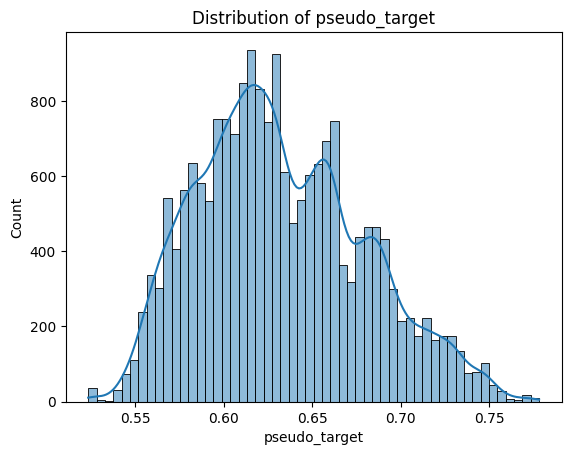

In [73]:
sns.histplot(new_df_sorted['pseudo_target'], kde=True) 
plt.title("Distribution of pseudo_target")
plt.xlabel('pseudo_target')
plt.ylabel("Count")

In [80]:
topmeals.to_csv('data/user_meals.csv', index=False)